In [33]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import os
from scattering_data import DataLoader
from vbi_elbo import MCElboMF, MCElboFG, correlation_from_covariance
import torch
import copy
import pickle as pkl
import matplotlib.pyplot as plt

# Loading Data

In [34]:
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
data_train = DataLoader(None, "som")
print(data_train.data.shape)

(451, 4)


# Mean field fit and analysis

In [35]:
torch.manual_seed(2)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1
model = MCElboMF(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 12000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute ELBO
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 2000 == 1999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 11933.365234375, Step [1999/12000]
theta mean: Parameter containing:
tensor([[ 0.0863,  1.1810, 13.3909, -1.1586, 12.4635, -0.7803,  0.9888,  0.9413,
          1.1300,  1.1285,  1.2031,  1.2551,  1.2576,  1.4181,  1.5893,  1.3299]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[8.4180e-04, 1.6016e-02, 1.5974e+00, 5.0256e-01, 1.6775e+00, 4.6679e-01,
         5.4890e-03, 3.7215e-03, 3.1809e-03, 3.0848e-03, 2.8607e-03, 3.5391e-03,
         3.5018e-03, 4.2380e-03, 4.8779e-03, 4.5202e-03]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 4.512813364930683
Loss: 11505.255859375, Step [3999/12000]
theta mean: Parameter containing:
tensor([[ 0.0800,  1.3047, 15.0073,  0.1747, 14.6183,  0.4684,  0.9868,  0.9340,
          1.1247,  1.1030,  1.1593,  1.1796,  1.1871,  1.2789,  1.4013,  1.1250]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[3.7892e-04, 6.8503e-03, 1.2622e+00, 1.8885e-01, 1.1894e+00, 1.5299e-01,
       

## Saving results

In [36]:
folder = "Outputs"
run_id = "som_mf_1_"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Fit plots

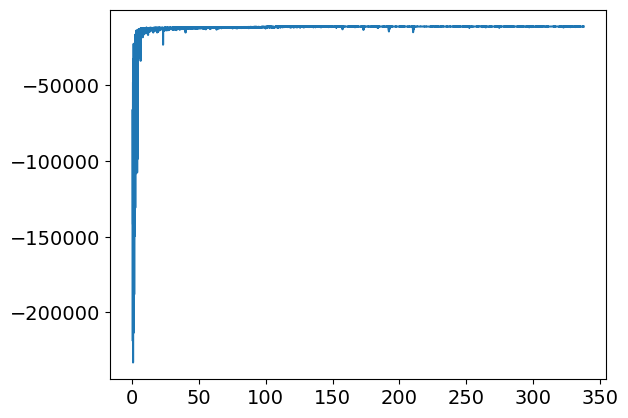

In [37]:
# ELBO
plt.plot(time_array[10:], -loss_array[10:])
plt.show()

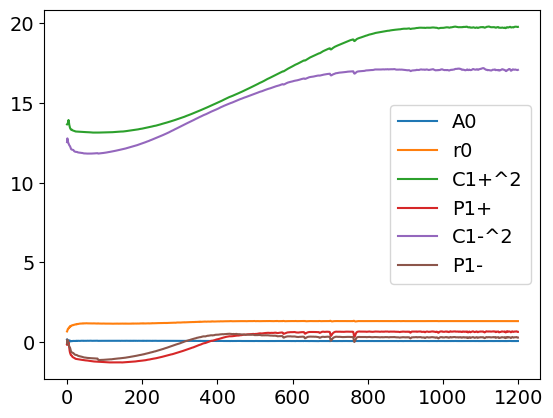

In [38]:
# Means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

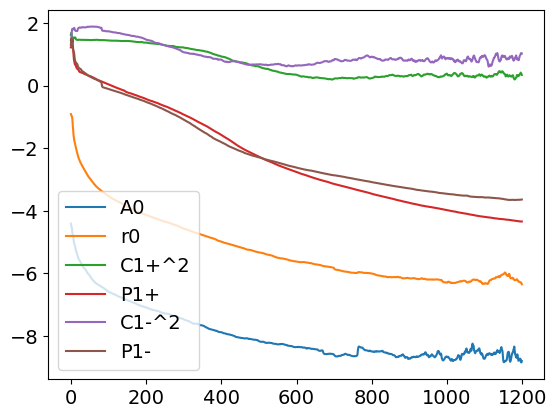

In [39]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

### Posteriors

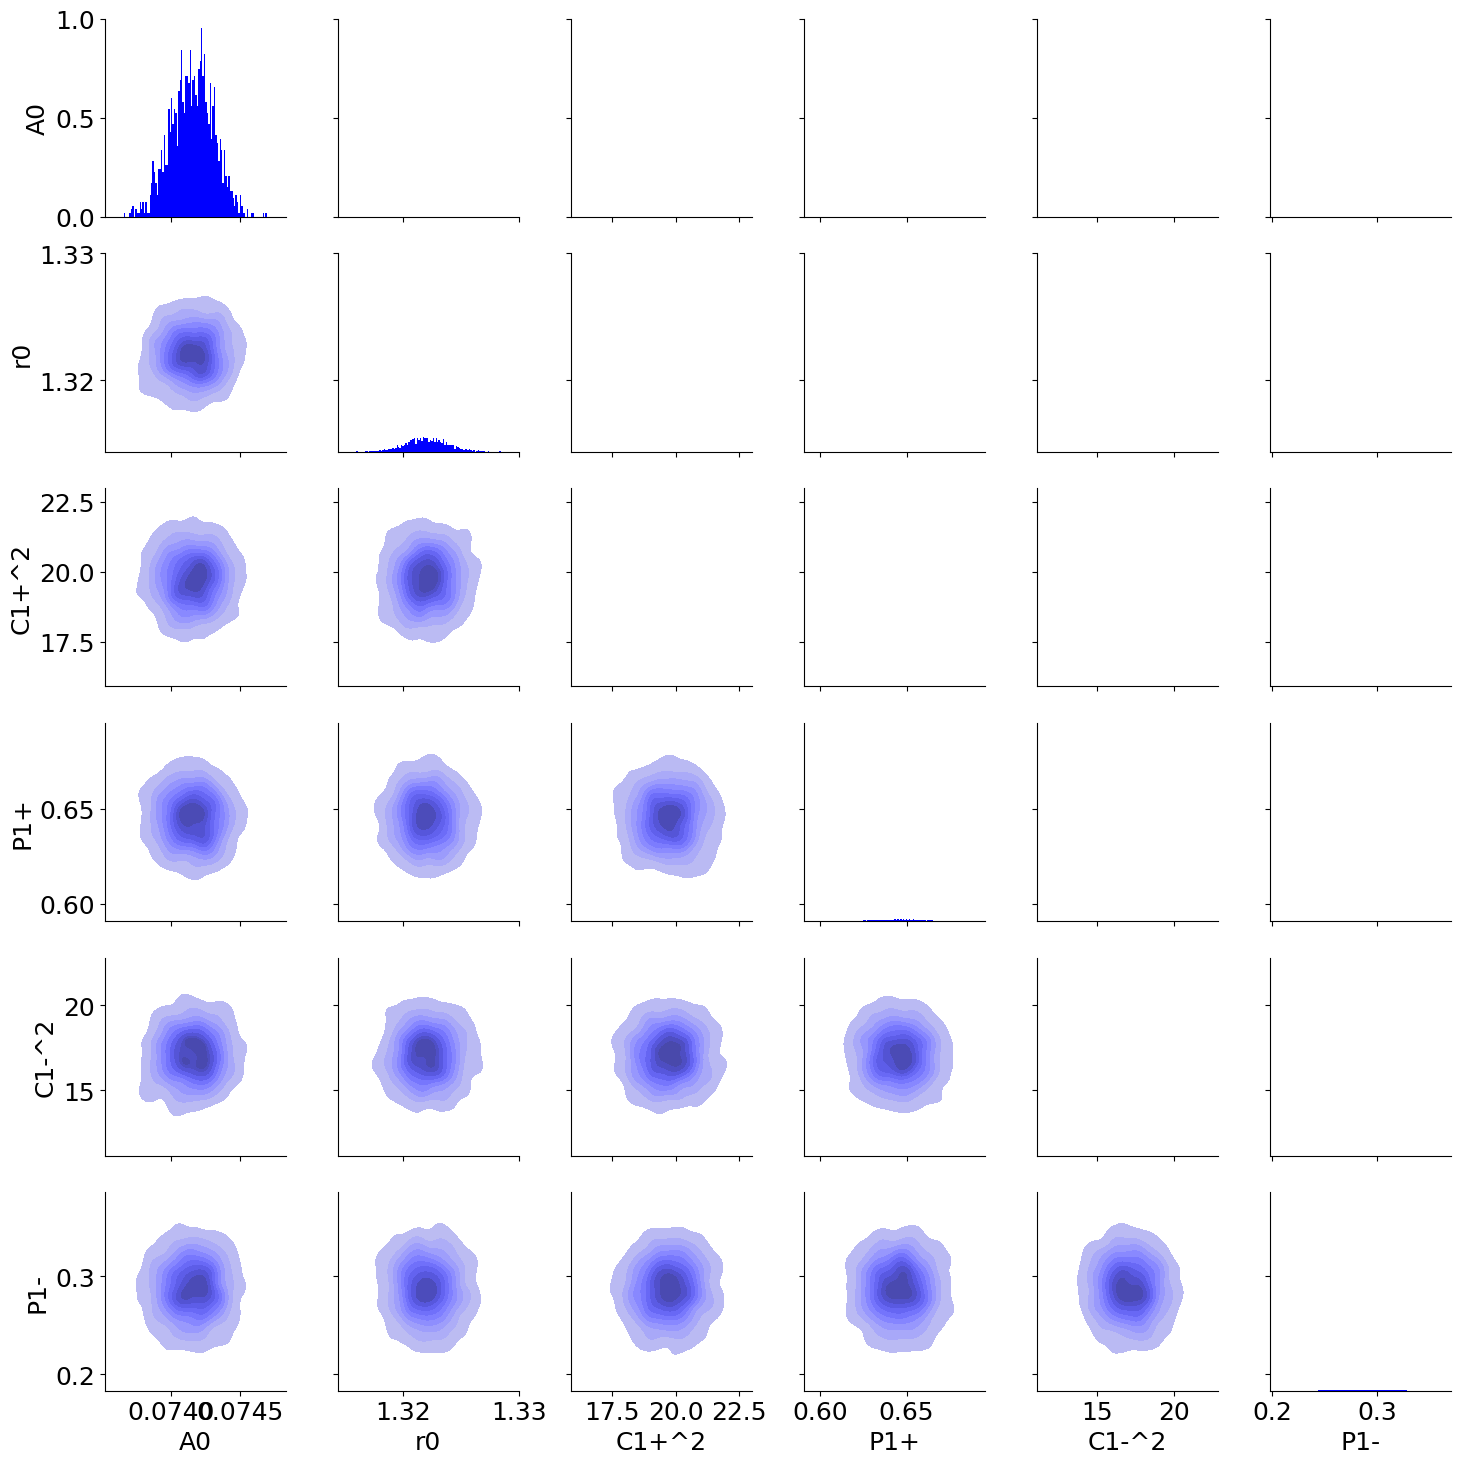

In [40]:
# VI Psoteriors
model.nMC = 1500
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

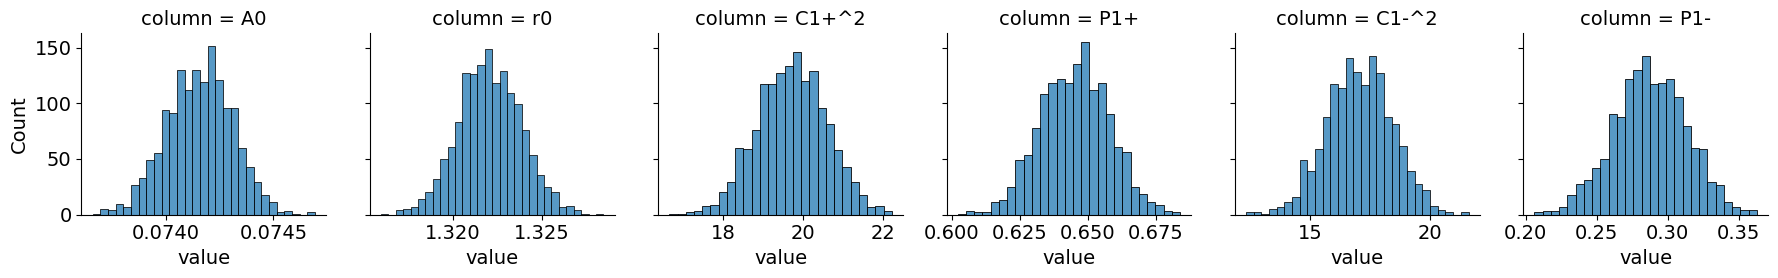

In [41]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()

<AxesSubplot:>

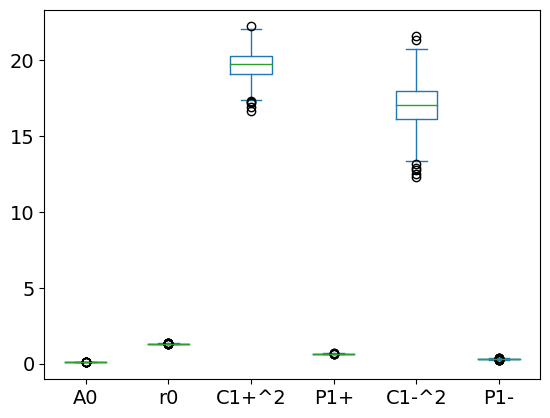

In [42]:
samples.plot(kind = "box")

# Full covariance fit and analysis

In [43]:
torch.manual_seed(2)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1

model = MCElboFG(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 25000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute ELBO
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 2000 == 1999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 64379.8671875, Step [1999/25000]
theta mean: Parameter containing:
tensor([[ 0.0442,  0.8499, 13.4278, -0.4310, 12.1922, -0.3969,  0.9747,  0.9266,
          1.0911,  1.0525,  1.0923,  1.1211,  1.1302,  1.2489,  1.4177,  1.1965]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0219, 0.2184, 1.6350, 1.3812, 1.9731, 1.3841, 0.0194, 0.0229, 0.0266,
         0.0229, 0.0211, 0.0252, 0.0173, 0.0332, 0.0291, 0.0363]],
       dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Minutes remaining 12.372188949173482
Loss: 14325.6142578125, Step [3999/25000]
theta mean: Parameter containing:
tensor([[ 0.0685,  1.0557, 13.0979, -0.7940, 11.8498, -0.7163,  0.9774,  0.9380,
          1.1242,  1.1138,  1.1783,  1.2152,  1.2247,  1.3507,  1.5126,  1.2640]],
       dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0154, 0.1307, 1.5715, 1.0135, 2.1752, 1.1068, 0.0101, 0.0113, 0.0131,
         0.0115, 0.0128, 0.0137, 0.0095, 0.0187, 0.0157, 0.0199]],
       dtype=

## Saving results

In [44]:
folder = "Outputs"
run_id = "som_full_1_"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Fit plots

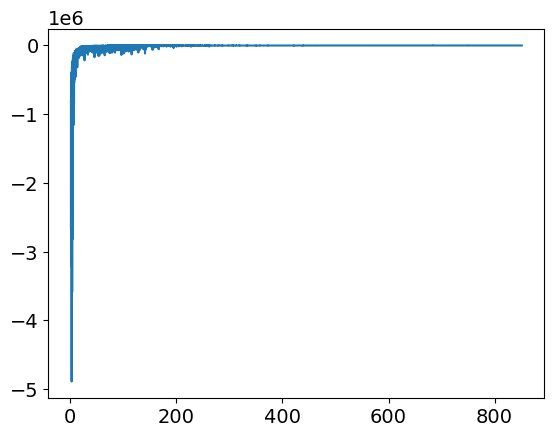

In [45]:
# ELBO
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

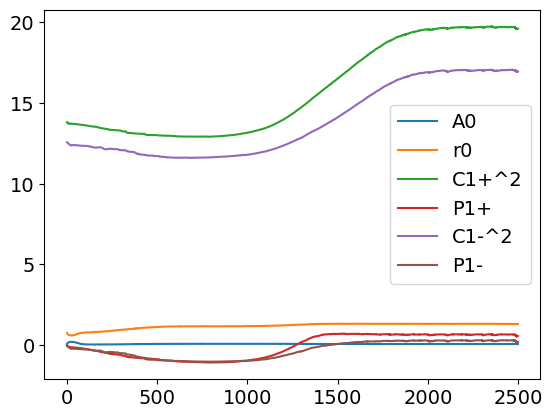

In [46]:
# means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

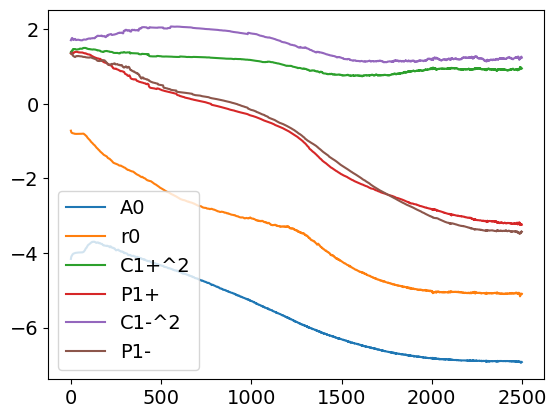

In [47]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

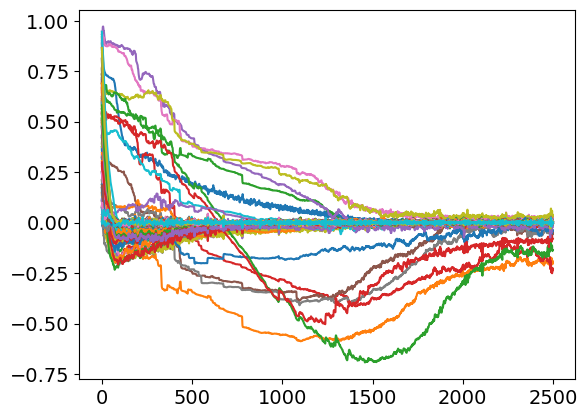

In [48]:
# Cholesky factor components for covariance matrix
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.show()

### Correlations

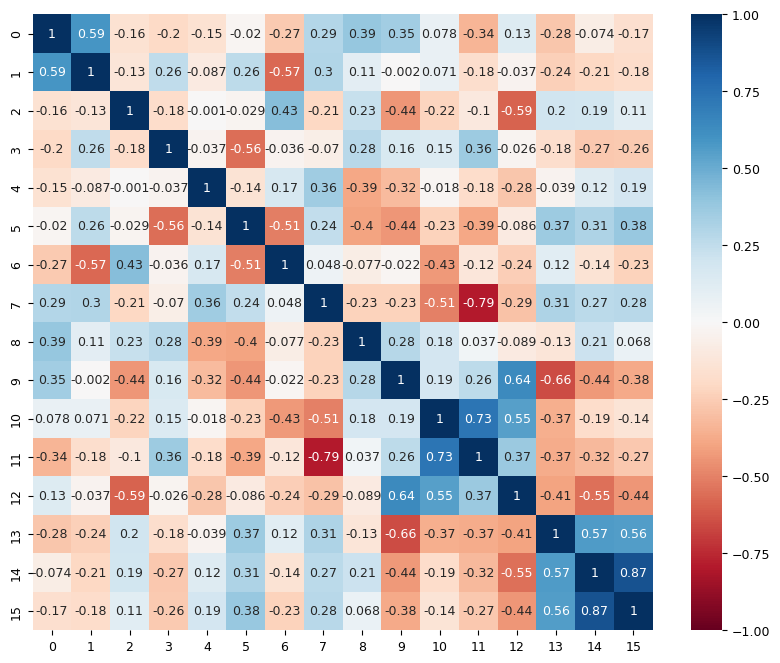

In [49]:
# All parameters
L = model.cholesky_factor()
S = L @ L.T
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 9})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3), vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

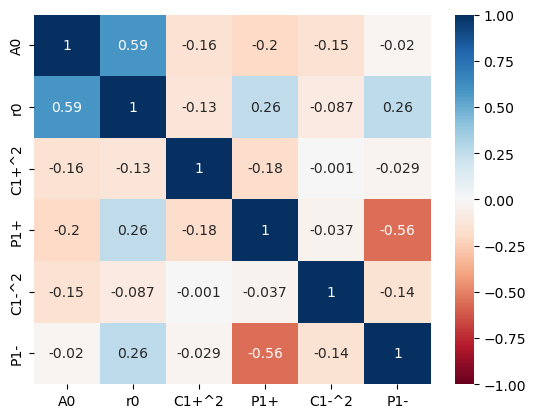

In [50]:
# Calibration parameters only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(pd.DataFrame(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[:6,:6], columns = names, index = names), vmin=-1, vmax=1, annot=True, cmap=cmap)
plt.show()

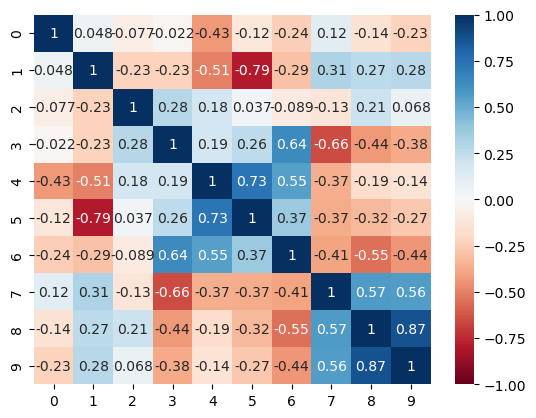

In [51]:
# Normalizing factors only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[6:,6:], vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

### Posteriors

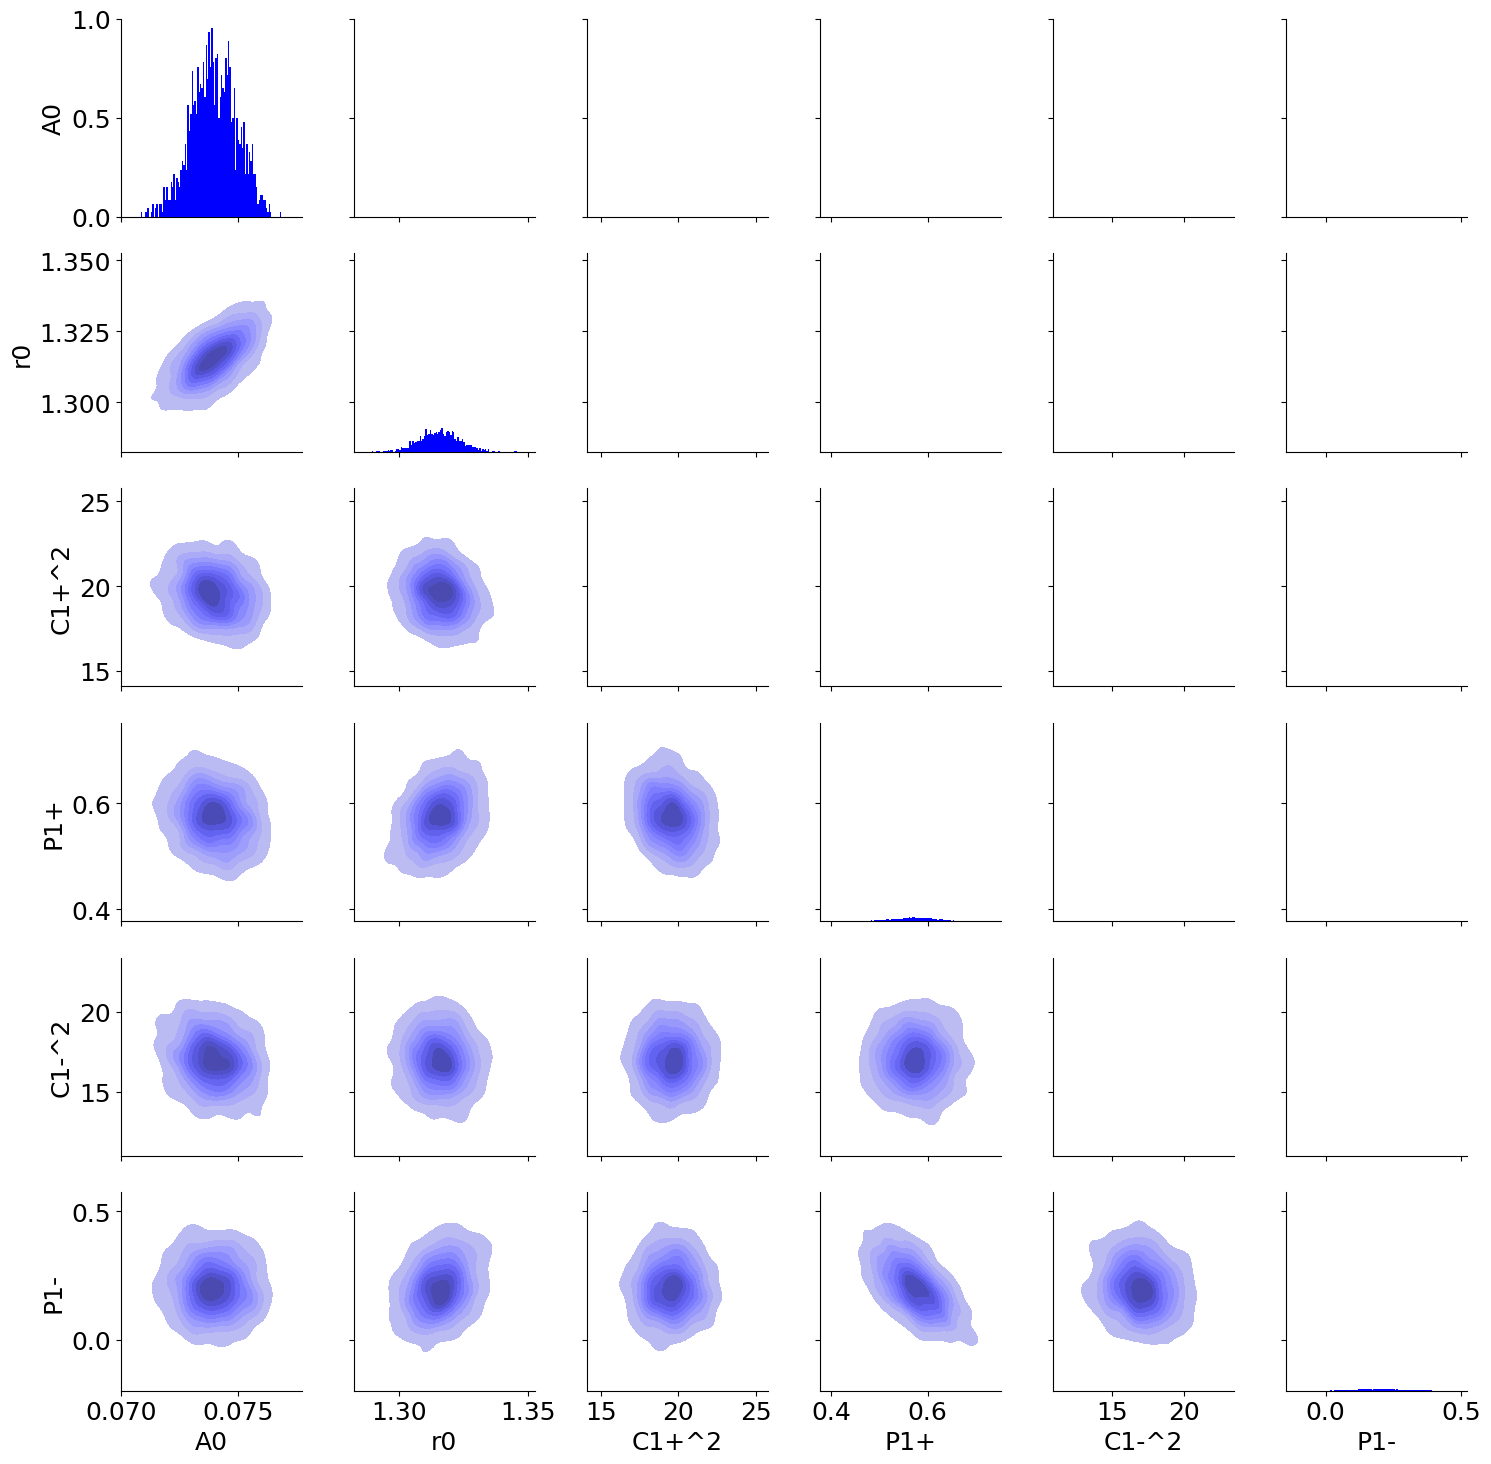

In [52]:
# VI Psoteriors
model.nMC = 1500
L = model.cholesky_factor()
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, L)   

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
g = sns.PairGrid(samples)
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()

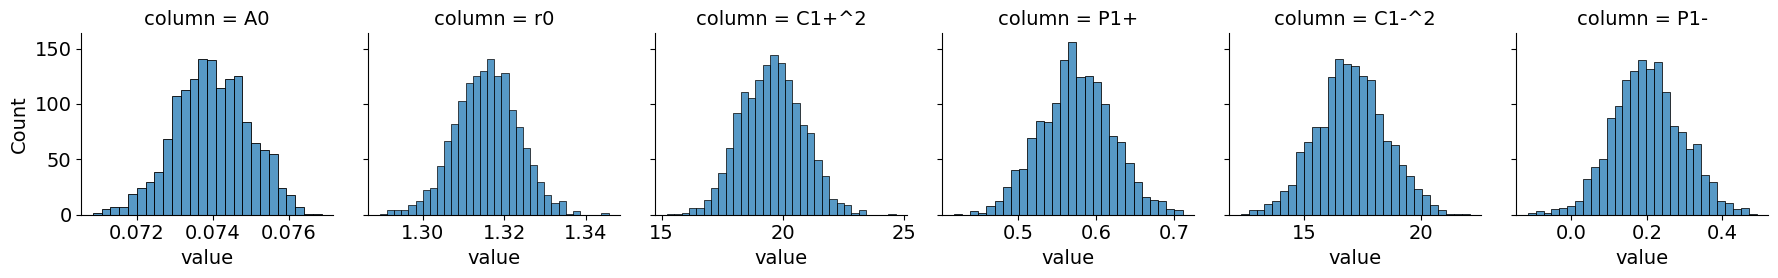

In [53]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(sns.histplot, 'value')
plt.show()

<AxesSubplot:>

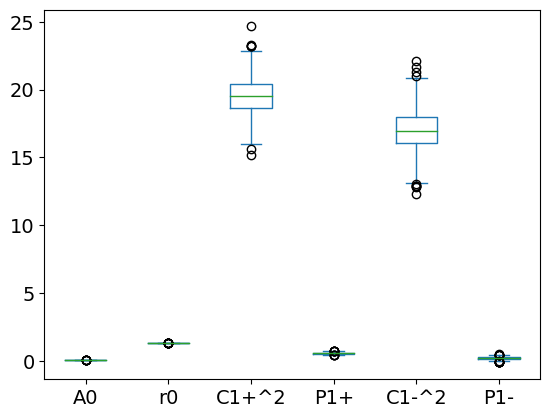

In [54]:
samples.plot(kind = "box")